## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [3]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

# Project

In [4]:
url = 'https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv'

In [5]:
df_data = pd.read_csv(url,sep=';',index_col=0,decimal=',')
df_data

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control
...,...,...
996,1000.000000,Treatment
997,1200.000000,Treatment
998,1500.000000,Treatment
999,2000.000000,Treatment


In [6]:
df_data.dtypes

value                float64
experimentVariant     object
dtype: object

In [7]:
df_data.describe()

,value
count,1000.000000
mean,18.674183
std,132.135045
min,6.436541
25%,9.414051
50%,10.020862
75%,10.669292
max,3000.000000


In [8]:
control = df_data.query('experimentVariant == "Control"')['value']
test = df_data.query('experimentVariant == "Treatment"')['value']

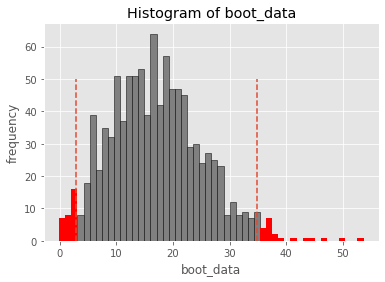

In [9]:
boot_data_mean = get_bootstrap(test,control)

In [10]:
boot_data_mean['p_value']

0.037199226878339604

In [11]:
boot_data_mean['quants']

,0
0.025,2.950639
0.975,34.808859


In [12]:
mannwhitneyu(test,control).pvalue

0.42960742912427896

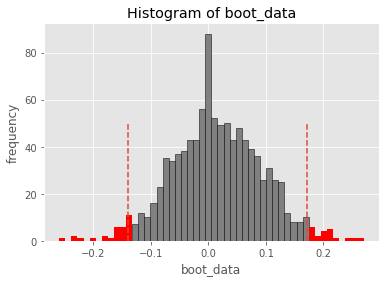

In [13]:
boot_data_мedian = get_bootstrap(test,control,statistic=np.median)

In [14]:
boot_data_мedian['p_value']

0.8462926812367428

In [15]:
boot_data_мedian['quants']

,0
0.025,-0.140049
0.975,0.170863


Бутстрэп с использованием медианы указывает на то, что выборки почти наверняка случайно различаются (97,5%), 0 входит в доверительный интервал, отклоняем H0. Выводы аналогичные с U-тестом

# Рассмотрим причины таких расхождений

In [16]:
import seaborn as sns
%matplotlib inline

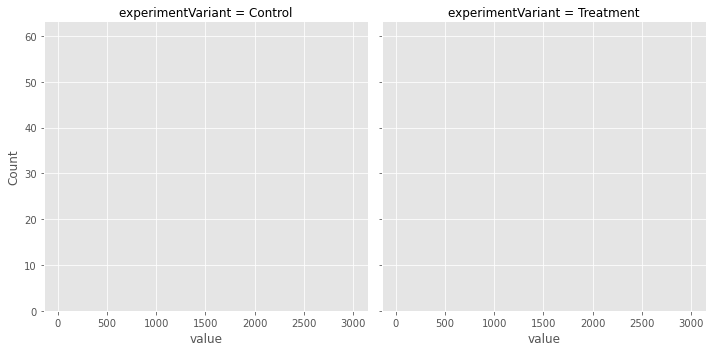

In [17]:
sns.displot(data=df_data,x='value',col='experimentVariant')

displot почему-то не дал ничего...
где ошибка?

<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

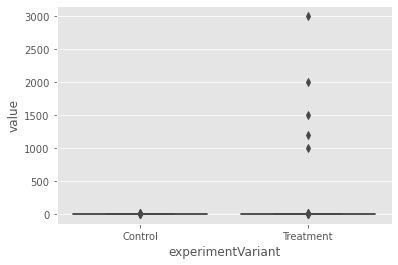

In [18]:
sns.boxplot(data=df_data,y='value',x='experimentVariant')

Есть сильные выбросы в тестовой группе, попробуем от них избавиться

<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

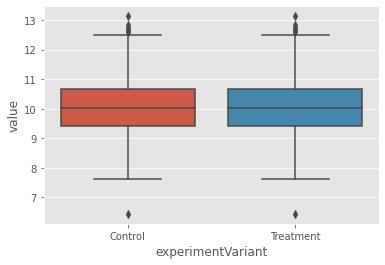

In [19]:
sns.boxplot(data=df_data.query('value<1000'),y='value',x='experimentVariant')

Выборки идентичные!

Что нам покажет Бутстреп на среднем значении с исправленными данными

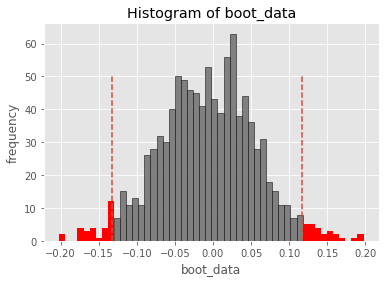

In [20]:
test_fitted = test[test < 1000]
boot_data_mean_fitted = get_bootstrap(test_fitted,control)

Теперь все сходится, выборки идентичные, различия ничтожны, кроме выборосов. Тут может быть что-то сокрыто, либо это просто ошибка данных